In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv("../data/interim/trigrams3.csv")
data = data.drop(['Unnamed: 0'], axis=1)
data['TRIGRAMS'] = data['TRIGRAMS'].apply(literal_eval)
data.head()

,NUM,FACILITY,DATE,FINE,NARRATIVE,TRIGRAMS
0,20008964,FREMONT HEALTHCARE CENTER,2012-02-01,750.0,F323 483.25(h) FREE OF ACCIDENT HAZARDS/SUPERV...,"[hazard_supervision_device, device_prevent_acc..."
1,20009068,WILLOW TREE NURSING CENTER,2012-03-02,750.0,Title 22 72520 (a) If a patient of a skilled n...,"[skilled_nursing_facility, hospital_define_sec..."
2,20009069,KINDRED NURSING AND REHABILITATION - YGNACIO V...,2012-03-02,750.0,483.12(b) (3) Permitting Resident to Return to...,"[bed_hold_period, facility_immediately_availab..."
3,20009078,"BAY VIEW REHABILITATION HOSPITAL, LLC",2012-03-05,37500.0,483.25 PROVIDE CARE/SERVICES FOR HIGHEST WELL ...,"[service_high_beingeach, facility_provide_nece..."
4,20009082,LONE TREE CONVALESCENT HOSPITAL,2012-03-06,600.0,T22 DIV5 CH3 ART3-72311(a)(1)(A) Nursing Servi...,"[nursing_service_shall, include_limit_followin..."


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
# Build a corpus of strings out of the trigram column in the main database

corpus = [' '.join(data.loc[row, 'TRIGRAMS']) for row in range(len(data))] 
corpus[0][0:100], corpus[1][0:100], corpus[2][0:100]

('hazard_supervision_device device_prevent_accident facility_violate_regulation receive_adequate_super',
 'skilled_nursing_facility hospital_define_section skilled_nursing_facility patient_bedhold_seven faci',
 'bed_hold_period facility_immediately_availability resident-_require_service facility_ii_eligible fac')

In [4]:
# Define a function that will convert the corpus into a vectorized bag of words, then apply it.
# The function also generates a continous outcome variable that is the amount of the fine.

def make_xy(data, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = data.FINE
    return X, y
X, y = make_xy(data)

<h3 style="color:blue">Multinomial Naive Bayes predicting the fine continuously</h3>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
foo = MultinomialNB()
foo.fit(X_train, y_train)
pred1_nb = foo.predict(X_train)
pred2_nb = foo.predict(X_test)
score1_nb = metrics.accuracy_score(y_train, pred1_nb)
score2_nb = metrics.accuracy_score(y_test, pred2_nb)
print(["training score:", score1_nb, "test score:", score2_nb])

['training score:', 0.6139742319127849, 'test score:', 0.4508670520231214]


<h3 style="color:red">Random Forest Generator predicting the fine continuously</h3>

In [6]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size = 0.3)

foo = RandomForestRegressor(max_depth = 4, random_state=48)
foo.fit(X_train_rf, y_train_rf)
pred1_rf = foo.predict(X_train_rf)
pred2_rf = foo.predict(X_test_rf)
score1_rf = foo.score(X_train_rf, y_train_rf)
score2_rf = foo.score(X_test_rf, y_test_rf)

print(["training score:", score1_rf, "test score:", score2_rf])

C:\Users\Jason GL\Anaconda3JGL\envs\biosphere\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['training score:', 0.8020783449332802, 'test score:', 0.5316033666552011]


<h3 style="color:#3cb371">Gradient Boosting Machine predicting the fine continuously</h3>

In [7]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X, y, test_size = 0.3)
foo = GradientBoostingRegressor(random_state=48, max_features=100, n_iter_no_change=8, 
                                 tol=0.001, n_estimators=200)
foo.fit(X_train_gb, y_train_gb)
pred1_gb = foo.predict(X_train_gb)
pred2_gb = foo.predict(X_test_gb)
score1_gb = foo.score(X_train_gb, y_train_gb)
score2_gb = foo.score(X_test_gb, y_test_gb)
print(["training score:", score1_gb, "test score:", score2_gb])

['training score:', 0.8414576911500216, 'test score:', 0.4201553651097273]


<h3>Summary of performance of continuous models</h3>

In [8]:
summary = pd.DataFrame(
    {"MultinomialNB": [score1_nb, score2_nb],
     "RandomForest": [score1_rf, score2_rf],
     "GradientBoost": [score1_gb, score2_gb]
    })
summary.index = ['Train', 'Test']
summary.round(3)

,MultinomialNB,RandomForest,GradientBoost
Train,0.614,0.802,0.841
Test,0.451,0.532,0.420


In [9]:
# The Random Forest model performed most accurately, so I will use it for illustration.

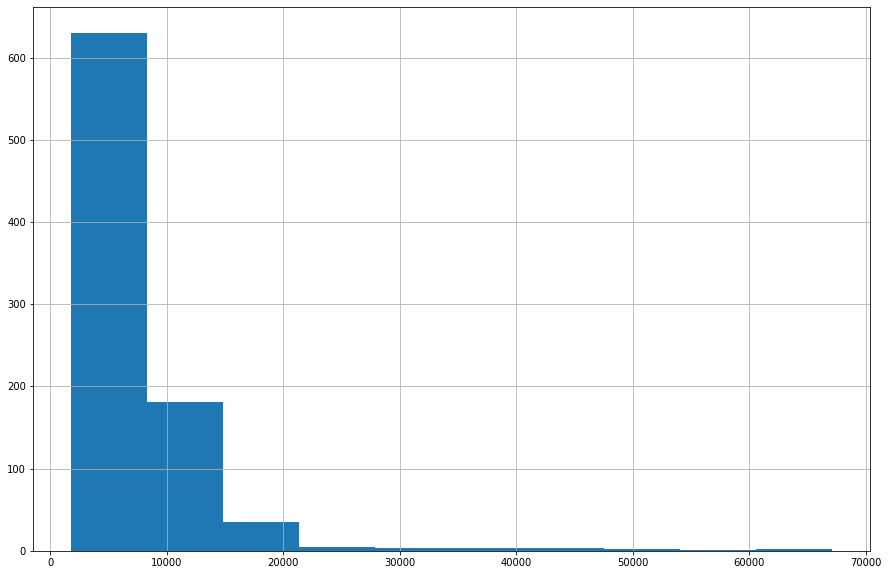

In [10]:
comparison = pd.DataFrame({"actual":y_test_rf, "pred":pred2_rf})
comparison['SqError'] = (comparison['actual'] - comparison['pred'])**2
comparison['pred'].hist()

In [11]:
# Calculate standard deviation of the random forest estimates
(sum(comparison['SqError'])/len(comparison))**0.5

7811.49899569638

In [12]:
# Calculate pearson correlation of the random forest estimates with the true values
import scipy as sp

sp.stats.pearsonr(comparison.actual, comparison.pred)

(0.7319703351800677, 5.754277271450478e-146)

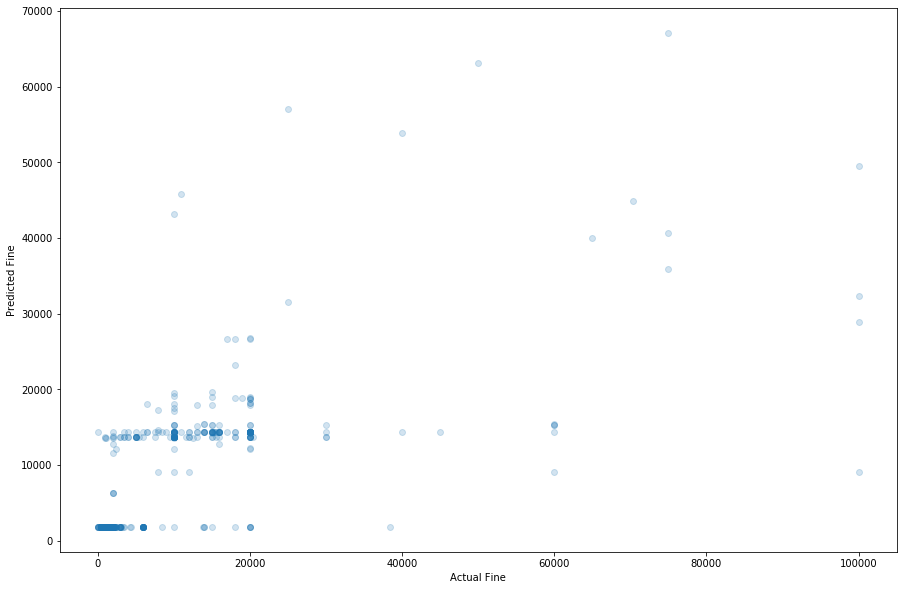

In [13]:
# Illustrate the scatterplot of actual fines vs. predicted fines

# Notice that the model is relatively good at predicting very high and very low fines,
# but the model tends to guess $15,000 for many ambiguous cases with little or no ability
# to discriminate between very low and moderately-low fines.

plt.scatter(comparison.actual, comparison.pred, alpha=0.2)
plt.xlabel('Actual Fine')
plt.ylabel('Predicted Fine')
plt.show()